---
title: "Dimensionality Reduction using Autoencoders"
description: "Autoencoder is unsupervised deep learning based technique. This blog implements Autoencoder using Pytorch on MNIST digits dataset."
date: "2025-01-11"
categories:
  - dimensionality reduction
  - deep learning
image: "images/autoencoder_image.png"
---

# Dimensionality Reduction with Autoencoders

## Curse of Dimensionality & Dimensionality Reduction
**Curse of Dimensionality**: A daunting challenge that haunts data scientists and machine learning practitioners alike. As number of features in the dataset increases, it is very difficult to analyze and extract meaningful insights out of the data. Following are some challenges while dealing with high dimensional data:

1. **Overfitting**: High dimensional datasets are prone to overfitting due to large number of parameters.   
2. **Issue with distance metrics**: Many machine learning algorithms rely on distance metrics (like Euclidean distance) to make decisions. In high-dimensional spaces, these metrics are often less reliable and tend to converge. In short, it is difficult to distinguish between close and far points.   
3. **Visualization**: Visualizing high dimensional data is very difficult which poses problem in identifying patterns / insights in data.   
4. **Sparsity**: In high dimensions, often data tend to be sparse because of which it is difficult for algorithms to find out meaningful patterns from the data.   

So, how to deal with high dimensional data and avoid curse of dimnensionality? This is where dimensionality reduction algorithms come to the rescue. One of the most popular and go-to dimensionality reduction algorithm is Principal Component Analysis (PCA).

PCA transforms the high dimensional data it into a new set of features called principal components. One can select few features / principal components which capture maximum variance in the dataset and thereby reduce the dimensionality of the dataset. It is very important to note that PCA is a linear algorithm and therefore can not capture non-linear patterns in the data.

Most of the real word high dimensional datasets are complex and contain non-linearities. Applications of PCA will be very limited in such complex datasets. Because of this non-linear dimensionality reduction algorithms are needed. Autoencoder is a deep learning based dimensionality reduction algorithm which is great at capturing complex non-linear patterns inside the data. In this blog, we will understand and implement Autonencoder for dimensionality reduction using Pytorch.




















## What is Autoencoder?
Autoencoder is a neural network used for unsupervised learning. Its primary goal is to learn an efficient representation (or encoding) of input data by training the network to map the input to a lower-dimensional space and then reconstruct it back to its original form. It consists of two main components: the encoder and the decoder. The encoder compresses the input data into a compact latent representation, while the decoder reconstructs the data from this compressed representation. Apart from dimensionality reduction, Autoencoders are widely used for others tasks such as denoising, anomaly detection, feature extraction and generating new data as well.

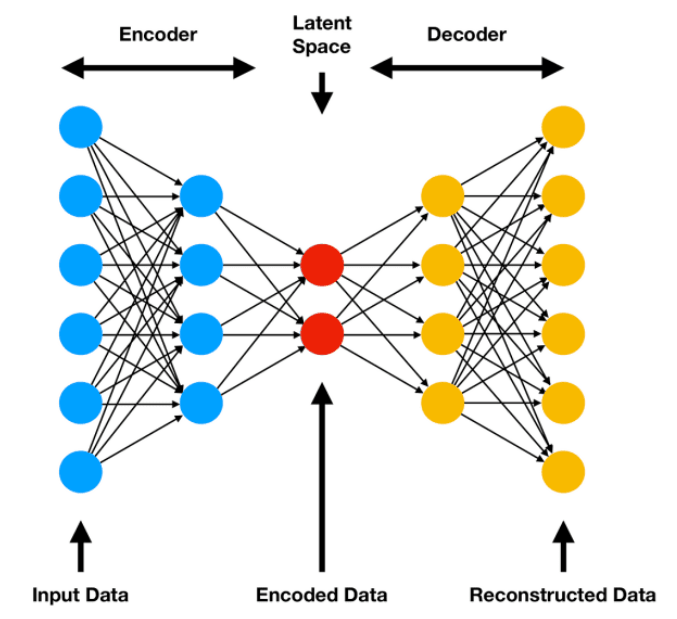







In this blog, we will apply Autoencoder to perform dimensionality reduction of MNIST digit dataset. MNIST digit dataset contains 28X28 grayscale images of handwritten digits. In the end, we will compare the results of Autoencoder to that of PCA.

## Import Packages
- We will use `torchinfo` package for getting summary of neural network.
- Weights and Biases will be used for logging the results of neural network training.

In [2]:
!pip -q install torchinfo

In [3]:
from google.colab import userdata
import matplotlib.pyplot as plt
import pandas as pd
import random
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from torchinfo import summary
from torch.optim.lr_scheduler import StepLR
import wandb
import plotly.express as px
wandb.login(key=userdata.get('WB_TOKEN'))

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: sonawane-ravindra1. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
torch.cuda.is_available()

True

In [ ]:
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

In [ ]:
device

'cuda'

## Load Data
- We load train and test dataset using torchvision package and then convert them into dataloaders.
- Train dataset consists of 60,000 grayscale images of handwritten digits while test dataset contains 10,000 grayscale images of handwritten digits.

In [ ]:
train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                      transform=transforms.ToTensor())

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True,
                                              num_workers=2)

In [ ]:
len(train_data)

60000

In [ ]:
len(train_dataloader)

938

In [ ]:
len(test_data)

10000

In [ ]:
len(test_dataloader)

157

## Inspect a few Images

In [ ]:
random_integers = [random.randint(0, 9999) for _ in range(9)]

In [ ]:
random_integers

[1651, 5652, 80, 2806, 4588, 5011, 4612, 5760, 8162]

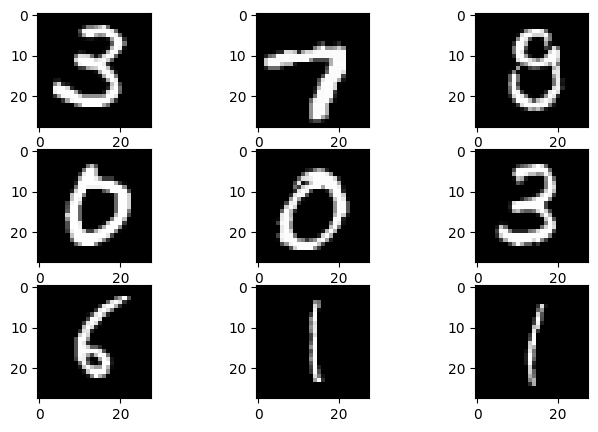

In [ ]:
fig, axes = plt.subplots(3, 3, figsize = (8, 5))
count = 0
for i in range(3):
  for j in range(3):
    image_index = random_integers[count]
    axes[i][j].imshow(train_data[image_index][0].reshape((28, 28)), cmap='gray')
    count = count + 1

## Create a Neural Network Architecture of Autoencoder
- First, We create encoder with 3 convolutional layers (with 64 filters each) and 3 fully connected layers. As you can see, the last layer in encoder has output shape of 2. The last layer in encoder is the compressed representation of the input and it is also called as latent space. The last layer in encoder is also called bottleneck.
- After that, we create decoder which performs opposite transformations as compared to encoder. Decoder attempts to regenerate the input by upsampling the compressed representation.
- You can notice that we have made use of `ConvTranspose2d` and `Unflatten` layers in decoder which are inverse of `Conv2d` and `Flatten` layers used in encoder.
- Generally, Autoencoders use MSE (Mean Square Error) loss between input and output. During training, we minimise the loss by using backpropogation. Since, we are using MSE loss, the shape of input and output must be same. In order to ensure the same shape, we have used `nn.functional.interpolate` method in the forward pass.
- As it can be seen in the summary, the model has 1,331,395 parameters.

In [ ]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3, padding=1, stride=2),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=2),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(64 * 4 * 4, 512),
        nn.ReLU(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Linear(128, 2)
    )

    self.decoder = nn.Sequential(
        nn.Linear(2, 128),
        nn.ReLU(),
        nn.Linear(128, 512),
        nn.ReLU(),
        nn.Linear(512, 64 * 4 * 4),
        nn.Unflatten(1, (64, 4, 4)),
        nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1, output_padding=1, stride=2),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1, output_padding=1, stride=2),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 1, kernel_size=3, padding=1, output_padding=1, stride=2),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    x = nn.functional.interpolate(x, size=(28, 28), mode='bilinear', align_corners=False)
    return x

In [ ]:
train_data[0][0].shape

torch.Size([1, 28, 28])

In [ ]:
model = AutoEncoder()
model = model.to(device)

In [ ]:
train_data[0][0].shape

torch.Size([1, 28, 28])

In [ ]:
train_data[0][0].unsqueeze(0).shape

torch.Size([1, 1, 28, 28])

In [ ]:
model.forward(train_data[0][0].unsqueeze(0).to(device)).shape

torch.Size([1, 1, 28, 28])

In [ ]:
summary(model, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [1, 1, 28, 28]            --
├─Sequential: 1-1                        [1, 2]                    --
│    └─Conv2d: 2-1                       [1, 64, 14, 14]           640
│    └─ReLU: 2-2                         [1, 64, 14, 14]           --
│    └─Conv2d: 2-3                       [1, 64, 7, 7]             36,928
│    └─ReLU: 2-4                         [1, 64, 7, 7]             --
│    └─Conv2d: 2-5                       [1, 64, 4, 4]             36,928
│    └─ReLU: 2-6                         [1, 64, 4, 4]             --
│    └─Flatten: 2-7                      [1, 1024]                 --
│    └─Linear: 2-8                       [1, 512]                  524,800
│    └─ReLU: 2-9                         [1, 512]                  --
│    └─Linear: 2-10                      [1, 128]                  65,664
│    └─ReLU: 2-11                        [1, 128]                  

## Let's Train a Baseline Autoencoder
- We implement a standard training loop in Pytorch and report loss to weights & biases after processing of every 100 batches.
- We can notice that after training for 10 epochs, training loss is 0.037 and test (validation) loss is 0.0348. Let's see how this model performs in terms of dimensionality reduction as compared to PCA.

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
criterion = nn.MSELoss()

In [ ]:
model = model.to(device)

In [ ]:
number_of_epochs = 10
wandb.init(project="autoencoder", entity="sonawane-ravindra1",
           config={})
for i in tqdm(range(number_of_epochs)):
  model.train()
  for batch_id, (data, _) in enumerate(train_dataloader):
    optimizer.zero_grad()
    data = data.to(device)
    output = model(data)
    loss = criterion(output, data)
    loss.backward()
    optimizer.step()
    if batch_id % 100 == 0:
      print(f"Epoch [{i+1}/{number_of_epochs}], Batch [{batch_id+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}")
      wandb.log({'train_loss': loss.item()}, step=i*len(train_dataloader) + batch_id)

  model.eval()
  val_loss = 0
  for data, _ in test_dataloader:
    data = data.to(device)
    output = model(data)
    loss = criterion(output, data)
    val_loss = val_loss + loss.item()

  val_loss = val_loss / len(test_dataloader)
  wandb.log({'val_loss': val_loss}, step=(i+1)*len(train_dataloader))
  print(f"Epoch [{i+1}/{number_of_epochs}], Validation Loss: {val_loss:.4f}")

wandb.finish()

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Batch [1/938], Loss: 0.2090
Epoch [1/10], Batch [101/938], Loss: 0.0733
Epoch [1/10], Batch [201/938], Loss: 0.0542
Epoch [1/10], Batch [301/938], Loss: 0.0532
Epoch [1/10], Batch [401/938], Loss: 0.0441
Epoch [1/10], Batch [501/938], Loss: 0.0442
Epoch [1/10], Batch [601/938], Loss: 0.0441
Epoch [1/10], Batch [701/938], Loss: 0.0415
Epoch [1/10], Batch [801/938], Loss: 0.0431
Epoch [1/10], Batch [901/938], Loss: 0.0439


 10%|█         | 1/10 [00:16<02:26, 16.23s/it]

Epoch [1/10], Validation Loss: 0.0421
Epoch [2/10], Batch [1/938], Loss: 0.0373
Epoch [2/10], Batch [101/938], Loss: 0.0439
Epoch [2/10], Batch [201/938], Loss: 0.0397
Epoch [2/10], Batch [301/938], Loss: 0.0431
Epoch [2/10], Batch [401/938], Loss: 0.0392
Epoch [2/10], Batch [501/938], Loss: 0.0434
Epoch [2/10], Batch [601/938], Loss: 0.0405
Epoch [2/10], Batch [701/938], Loss: 0.0395
Epoch [2/10], Batch [801/938], Loss: 0.0385
Epoch [2/10], Batch [901/938], Loss: 0.0394


 20%|██        | 2/10 [00:29<01:57, 14.71s/it]

Epoch [2/10], Validation Loss: 0.0389
Epoch [3/10], Batch [1/938], Loss: 0.0405
Epoch [3/10], Batch [101/938], Loss: 0.0401
Epoch [3/10], Batch [201/938], Loss: 0.0391
Epoch [3/10], Batch [301/938], Loss: 0.0365
Epoch [3/10], Batch [401/938], Loss: 0.0405
Epoch [3/10], Batch [501/938], Loss: 0.0395
Epoch [3/10], Batch [601/938], Loss: 0.0386
Epoch [3/10], Batch [701/938], Loss: 0.0352
Epoch [3/10], Batch [801/938], Loss: 0.0398
Epoch [3/10], Batch [901/938], Loss: 0.0371


 30%|███       | 3/10 [00:43<01:40, 14.42s/it]

Epoch [3/10], Validation Loss: 0.0375
Epoch [4/10], Batch [1/938], Loss: 0.0368
Epoch [4/10], Batch [101/938], Loss: 0.0377
Epoch [4/10], Batch [201/938], Loss: 0.0380
Epoch [4/10], Batch [301/938], Loss: 0.0391
Epoch [4/10], Batch [401/938], Loss: 0.0362
Epoch [4/10], Batch [501/938], Loss: 0.0386
Epoch [4/10], Batch [601/938], Loss: 0.0381
Epoch [4/10], Batch [701/938], Loss: 0.0324
Epoch [4/10], Batch [801/938], Loss: 0.0353
Epoch [4/10], Batch [901/938], Loss: 0.0391


 40%|████      | 4/10 [00:56<01:23, 13.88s/it]

Epoch [4/10], Validation Loss: 0.0365
Epoch [5/10], Batch [1/938], Loss: 0.0352
Epoch [5/10], Batch [101/938], Loss: 0.0367
Epoch [5/10], Batch [201/938], Loss: 0.0368
Epoch [5/10], Batch [301/938], Loss: 0.0345
Epoch [5/10], Batch [401/938], Loss: 0.0332
Epoch [5/10], Batch [501/938], Loss: 0.0396
Epoch [5/10], Batch [601/938], Loss: 0.0390
Epoch [5/10], Batch [701/938], Loss: 0.0355
Epoch [5/10], Batch [801/938], Loss: 0.0330
Epoch [5/10], Batch [901/938], Loss: 0.0393


 50%|█████     | 5/10 [01:11<01:10, 14.15s/it]

Epoch [5/10], Validation Loss: 0.0365
Epoch [6/10], Batch [1/938], Loss: 0.0409
Epoch [6/10], Batch [101/938], Loss: 0.0366
Epoch [6/10], Batch [201/938], Loss: 0.0329
Epoch [6/10], Batch [301/938], Loss: 0.0375
Epoch [6/10], Batch [401/938], Loss: 0.0318
Epoch [6/10], Batch [501/938], Loss: 0.0337
Epoch [6/10], Batch [601/938], Loss: 0.0374
Epoch [6/10], Batch [701/938], Loss: 0.0392
Epoch [6/10], Batch [801/938], Loss: 0.0354
Epoch [6/10], Batch [901/938], Loss: 0.0354


 60%|██████    | 6/10 [01:25<00:55, 13.89s/it]

Epoch [6/10], Validation Loss: 0.0358
Epoch [7/10], Batch [1/938], Loss: 0.0362
Epoch [7/10], Batch [101/938], Loss: 0.0350
Epoch [7/10], Batch [201/938], Loss: 0.0382
Epoch [7/10], Batch [301/938], Loss: 0.0365
Epoch [7/10], Batch [401/938], Loss: 0.0358
Epoch [7/10], Batch [501/938], Loss: 0.0347
Epoch [7/10], Batch [601/938], Loss: 0.0358
Epoch [7/10], Batch [701/938], Loss: 0.0354
Epoch [7/10], Batch [801/938], Loss: 0.0376
Epoch [7/10], Batch [901/938], Loss: 0.0339


 70%|███████   | 7/10 [01:37<00:40, 13.44s/it]

Epoch [7/10], Validation Loss: 0.0354
Epoch [8/10], Batch [1/938], Loss: 0.0366
Epoch [8/10], Batch [101/938], Loss: 0.0355
Epoch [8/10], Batch [201/938], Loss: 0.0353
Epoch [8/10], Batch [301/938], Loss: 0.0353
Epoch [8/10], Batch [401/938], Loss: 0.0360
Epoch [8/10], Batch [501/938], Loss: 0.0359
Epoch [8/10], Batch [601/938], Loss: 0.0364
Epoch [8/10], Batch [701/938], Loss: 0.0369
Epoch [8/10], Batch [801/938], Loss: 0.0342
Epoch [8/10], Batch [901/938], Loss: 0.0340


 80%|████████  | 8/10 [01:50<00:26, 13.29s/it]

Epoch [8/10], Validation Loss: 0.0350
Epoch [9/10], Batch [1/938], Loss: 0.0360
Epoch [9/10], Batch [101/938], Loss: 0.0346
Epoch [9/10], Batch [201/938], Loss: 0.0383
Epoch [9/10], Batch [301/938], Loss: 0.0318
Epoch [9/10], Batch [401/938], Loss: 0.0344
Epoch [9/10], Batch [501/938], Loss: 0.0335
Epoch [9/10], Batch [601/938], Loss: 0.0369
Epoch [9/10], Batch [701/938], Loss: 0.0354
Epoch [9/10], Batch [801/938], Loss: 0.0343
Epoch [9/10], Batch [901/938], Loss: 0.0371


 90%|█████████ | 9/10 [02:03<00:13, 13.35s/it]

Epoch [9/10], Validation Loss: 0.0350
Epoch [10/10], Batch [1/938], Loss: 0.0330
Epoch [10/10], Batch [101/938], Loss: 0.0333
Epoch [10/10], Batch [201/938], Loss: 0.0368
Epoch [10/10], Batch [301/938], Loss: 0.0333
Epoch [10/10], Batch [401/938], Loss: 0.0333
Epoch [10/10], Batch [501/938], Loss: 0.0365
Epoch [10/10], Batch [601/938], Loss: 0.0354
Epoch [10/10], Batch [701/938], Loss: 0.0334
Epoch [10/10], Batch [801/938], Loss: 0.0372
Epoch [10/10], Batch [901/938], Loss: 0.0370


100%|██████████| 10/10 [02:17<00:00, 13.75s/it]

Epoch [10/10], Validation Loss: 0.0348


train_loss,█▅▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▂▂▁▁▂▂▁▂▂▁▁▂▁▂▁▁▂▁▁▁▁▂
val_loss,█▅▄▃▃▂▂▁▁▁
train_loss,0.037
val_loss,0.03479


## Save and Load the Model
We will save the trained model weights to google drive. After that, we load the weights back in another model which can be used for inference.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/autoencoder_mnist_1.pth'
torch.save(model.state_dict(), file_path)

Mounted at /content/drive


In [ ]:
loaded_model = AutoEncoder()
state_dict = torch.load(file_path, weights_only=True)
loaded_model.load_state_dict(state_dict)
loaded_model.eval()
loaded_model = loaded_model.to(device)

## Generate Images
- As we discussed earlier, Autoencoder compresses the input representation and then reconstructs it into its original form. Let's try to visualize how the reconstruction looks like for a few examples in train and test data.
- The Autoencoder is quite good at reconstruction of images. The generated images are blurred version of the original images. This can be attributed to simpler model / limited training.

In [ ]:
def plot_original_and_generated_images(index_to_show, data, model_):
  model_ = model_.to(device)
  original_image = data[index_to_show][0].reshape(28, 28)
  generated_image = model_(data[index_to_show][0].unsqueeze(0).to(device))
  generated_image = generated_image.reshape(shape=(28, 28))
  generated_image = generated_image.cpu().detach().numpy()

  fig, axes = plt.subplots(1, 2, figsize = (10, 5))
  axes[0].imshow(original_image, cmap='gray')
  axes[0].set_title('Original Image')

  axes[1].imshow(generated_image, cmap='gray')
  axes[1].set_title('Generated Image')

  return fig

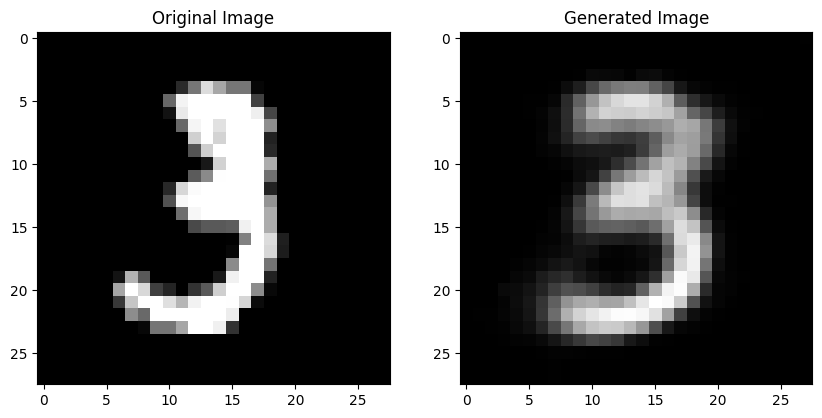

In [ ]:
index_to_show = 10
fig = plot_original_and_generated_images(index_to_show, train_data, loaded_model)

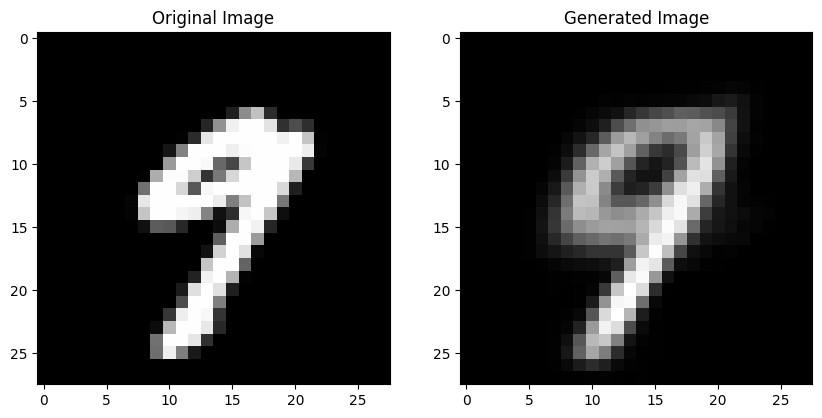

In [ ]:
index_to_show = 20
fig = plot_original_and_generated_images(index_to_show, test_data, loaded_model)

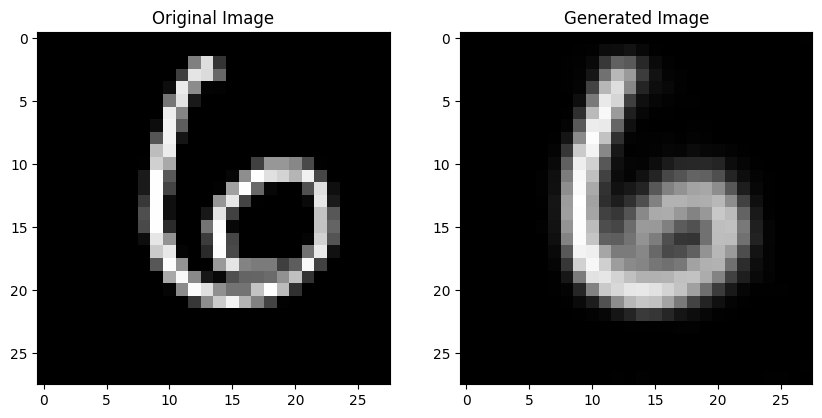

In [ ]:
index_to_show = 100
fig = plot_original_and_generated_images(index_to_show, test_data, loaded_model)

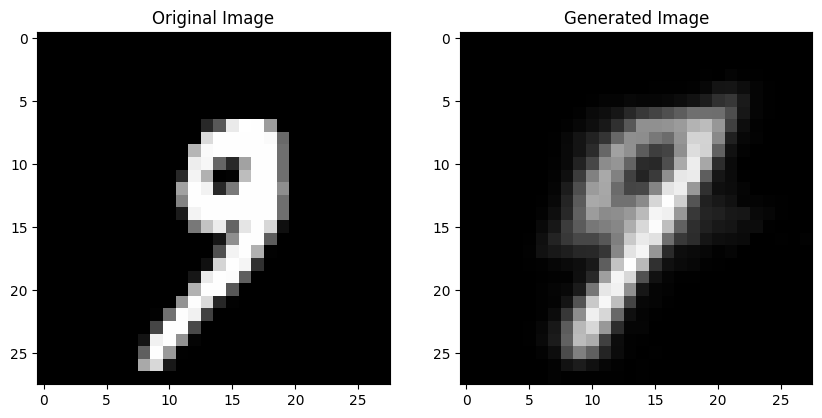

In [ ]:
index_to_show = 1000
fig = plot_original_and_generated_images(index_to_show, test_data, loaded_model)

## Let's Plot the Latent Space
- In this section, we plot 2D latent space of 10,000 test examples. After that, we compare it with the output of PCA with 2 principal components.
- We can observe from the plot of Latent Space that Autoencoder has performed quite great for the dimensionality reduction task. There is slight overlap between 9 and 4. The overlap can be attributed to simpler model and limited training time (we trained for only 10 epochs).
- In addition, the issue can also be due to the latent space being too small. We can try running a model with 3 dimensional latent space and see if it removes this issue.
- On the other hand, PCA has not been able to correctly cluster the handwritten digits. This was expected as PCA is linear technique.

In [ ]:
latent_df = pd.DataFrame()
for data, label in test_dataloader:
  temp_df = pd.DataFrame()
  data = data.to(device)
  loaded_model = loaded_model.to(device)
  latent_represenation = loaded_model.encoder(data)
  temp_df[['latent_x', 'latent_y']] = latent_represenation.detach().cpu().numpy()
  temp_df['label'] = label
  latent_df = pd.concat([temp_df, latent_df], ignore_index=True)
latent_df = latent_df.reset_index(drop=True)

In [ ]:
latent_df.shape

(10000, 3)

In [ ]:
latent_df.head(2)

,latent_x,latent_y,label
0,1.059678,1.287576,9
1,8.858256,-4.525108,1


<Axes: xlabel='latent_x', ylabel='latent_y'>

<IPython.core.display.Javascript object>

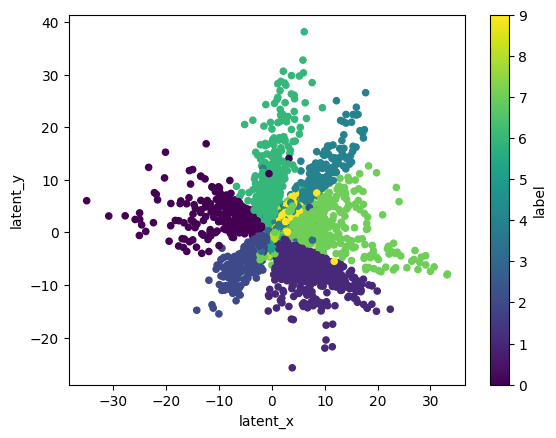

In [ ]:
%matplotlib inline
latent_df.plot(kind='scatter', x='latent_x', y='latent_y', c='label', cmap='viridis')

In [ ]:
len(train_data)

60000

In [ ]:
train_data_np = train_data.data.numpy()
train_data_np = train_data_np.reshape(train_data_np.shape[0], -1)
test_data_np = test_data.data.numpy()
test_data_np = test_data_np.reshape(test_data_np.shape[0], -1)

In [ ]:
train_data_np.shape

(60000, 784)

In [ ]:
pca_model = PCA(n_components=2)
pca_model.fit(train_data_np)

PCA(n_components=2)

In [ ]:
test_data_with_pca = pca_model.transform(test_data_np)
test_data_with_pca.shape

(10000, 2)

In [ ]:
pca_df = pd.DataFrame()
pca_df[['pca_x', 'pca_y']] = test_data_with_pca

label_df = pd.DataFrame()
for _, label in test_dataloader:
  temp_df = pd.DataFrame()
  temp_df['label'] = label
  label_df = pd.concat([temp_df, label_df], ignore_index=True)

pca_df = pd.concat([pca_df, label_df], axis = 1)

In [ ]:
pca_df.head(2)

,pca_x,pca_y,label
0,-332.271169,-747.798716,8
1,20.696962,955.584583,4


<Axes: xlabel='pca_x', ylabel='pca_y'>

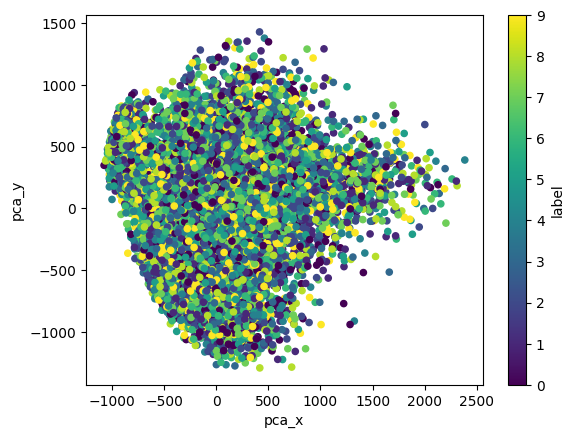

In [ ]:
pca_df.plot(kind='scatter', x='pca_x', y='pca_y', c='label', cmap='viridis')

## Autoencoder with 3-dimensional Latent Space
- We create the Autoencoder with the same architecture as that in the earlier step and only change the latent space dimension to 3.
- Next, we wrap the training of Autoencoder inside a function for easy experimentation.
- In this experiment, we also use step Learning Rate scheduler. It will reduce the learning as we train the model which helps in finding global minima (since the step size keep on reducing as the training progresses)

In [ ]:
class AutoEncoder_1(nn.Module):
  def __init__(self):
    super(AutoEncoder_1, self).__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3, padding=1, stride=2),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=2),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(64 * 4 * 4, 512),
        nn.ReLU(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Linear(128, 3)
    )

    self.decoder = nn.Sequential(
        nn.Linear(3, 128),
        nn.ReLU(),
        nn.Linear(128, 512),
        nn.ReLU(),
        nn.Linear(512, 64 * 4 * 4),
        nn.ReLU(),
        nn.Unflatten(1, (64, 4, 4)),
        nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1, output_padding=1, stride=2),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1, output_padding=1, stride=2),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 1, kernel_size=3, padding=1, output_padding=1, stride=2),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    x = nn.functional.interpolate(x, size=(28, 28), mode='bilinear', align_corners=False)
    return x

In [ ]:
model_1 = AutoEncoder_1()

In [ ]:
summary(model_1, input_size = (1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder_1                            [1, 1, 28, 28]            --
├─Sequential: 1-1                        [1, 3]                    --
│    └─Conv2d: 2-1                       [1, 64, 14, 14]           640
│    └─ReLU: 2-2                         [1, 64, 14, 14]           --
│    └─Conv2d: 2-3                       [1, 64, 7, 7]             36,928
│    └─ReLU: 2-4                         [1, 64, 7, 7]             --
│    └─Conv2d: 2-5                       [1, 64, 4, 4]             36,928
│    └─ReLU: 2-6                         [1, 64, 4, 4]             --
│    └─Flatten: 2-7                      [1, 1024]                 --
│    └─Linear: 2-8                       [1, 512]                  524,800
│    └─ReLU: 2-9                         [1, 512]                  --
│    └─Linear: 2-10                      [1, 128]                  65,664
│    └─ReLU: 2-11                        [1, 128]                  

In [ ]:
def train_model(model, train_dataloader, test_dataloader, number_of_epochs, learning_rate, config={}):
  if wandb.run is not None:
    wandb.finish()
  wandb.init(project="autoencoder", entity="sonawane-ravindra1",
             config=config, reinit=True)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  scheduler = StepLR(optimizer, step_size=2, gamma=0.5)
  criterion = nn.MSELoss()
  for i in tqdm(range(number_of_epochs)):
    model.train()
    for batch_id, (data, _) in enumerate(train_dataloader):
      optimizer.zero_grad()
      data = data.to(device)
      output = model(data)
      loss = criterion(output, data)
      loss.backward()
      optimizer.step()
      if batch_id % 100 == 0:
        print(f"Epoch [{i+1}/{number_of_epochs}], Batch [{batch_id+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}")
        wandb.log({'train_loss': loss.item(),
                   'learning_rate': optimizer.param_groups[0]['lr']}, step=i*len(train_dataloader) + batch_id)

    model.eval()
    val_loss = 0
    for data, _ in test_dataloader:
      data = data.to(device)
      output = model(data)
      loss = criterion(output, data)
      val_loss = val_loss + loss.item()

    val_loss = val_loss / len(test_dataloader)
    wandb.log({'val_loss': val_loss}, step=(i+1)*len(train_dataloader))
    print(f"Epoch [{i+1}/{number_of_epochs}], Validation Loss: {val_loss:.4f}")
    scheduler.step()

  wandb.finish()
  return model

In [ ]:
model_1 = train_model(model_1, train_dataloader, test_dataloader, number_of_epochs=10,
                      learning_rate=0.001, config={})

learning_rate,▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▁▁▁▁▁▁▁
learning_rate,0.001
train_loss,0.03555


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Batch [1/938], Loss: 0.2287
Epoch [1/10], Batch [101/938], Loss: 0.0722
Epoch [1/10], Batch [201/938], Loss: 0.0599
Epoch [1/10], Batch [301/938], Loss: 0.0550
Epoch [1/10], Batch [401/938], Loss: 0.0487
Epoch [1/10], Batch [501/938], Loss: 0.0459
Epoch [1/10], Batch [601/938], Loss: 0.0441
Epoch [1/10], Batch [701/938], Loss: 0.0420
Epoch [1/10], Batch [801/938], Loss: 0.0428
Epoch [1/10], Batch [901/938], Loss: 0.0391


 10%|█         | 1/10 [00:14<02:10, 14.45s/it]

Epoch [1/10], Validation Loss: 0.0386
Epoch [2/10], Batch [1/938], Loss: 0.0382
Epoch [2/10], Batch [101/938], Loss: 0.0351
Epoch [2/10], Batch [201/938], Loss: 0.0375
Epoch [2/10], Batch [301/938], Loss: 0.0378
Epoch [2/10], Batch [401/938], Loss: 0.0343
Epoch [2/10], Batch [501/938], Loss: 0.0352
Epoch [2/10], Batch [601/938], Loss: 0.0360
Epoch [2/10], Batch [701/938], Loss: 0.0400
Epoch [2/10], Batch [801/938], Loss: 0.0368
Epoch [2/10], Batch [901/938], Loss: 0.0334


 20%|██        | 2/10 [00:27<01:48, 13.59s/it]

Epoch [2/10], Validation Loss: 0.0342
Epoch [3/10], Batch [1/938], Loss: 0.0329
Epoch [3/10], Batch [101/938], Loss: 0.0368
Epoch [3/10], Batch [201/938], Loss: 0.0304
Epoch [3/10], Batch [301/938], Loss: 0.0319
Epoch [3/10], Batch [401/938], Loss: 0.0370
Epoch [3/10], Batch [501/938], Loss: 0.0341
Epoch [3/10], Batch [601/938], Loss: 0.0367
Epoch [3/10], Batch [701/938], Loss: 0.0343
Epoch [3/10], Batch [801/938], Loss: 0.0313
Epoch [3/10], Batch [901/938], Loss: 0.0298


 30%|███       | 3/10 [00:40<01:34, 13.51s/it]

Epoch [3/10], Validation Loss: 0.0328
Epoch [4/10], Batch [1/938], Loss: 0.0346
Epoch [4/10], Batch [101/938], Loss: 0.0332
Epoch [4/10], Batch [201/938], Loss: 0.0330
Epoch [4/10], Batch [301/938], Loss: 0.0324
Epoch [4/10], Batch [401/938], Loss: 0.0321
Epoch [4/10], Batch [501/938], Loss: 0.0341
Epoch [4/10], Batch [601/938], Loss: 0.0306
Epoch [4/10], Batch [701/938], Loss: 0.0333
Epoch [4/10], Batch [801/938], Loss: 0.0319
Epoch [4/10], Batch [901/938], Loss: 0.0319


 40%|████      | 4/10 [00:55<01:22, 13.82s/it]

Epoch [4/10], Validation Loss: 0.0322
Epoch [5/10], Batch [1/938], Loss: 0.0338
Epoch [5/10], Batch [101/938], Loss: 0.0334
Epoch [5/10], Batch [201/938], Loss: 0.0336
Epoch [5/10], Batch [301/938], Loss: 0.0286
Epoch [5/10], Batch [401/938], Loss: 0.0347
Epoch [5/10], Batch [501/938], Loss: 0.0310
Epoch [5/10], Batch [601/938], Loss: 0.0310
Epoch [5/10], Batch [701/938], Loss: 0.0335
Epoch [5/10], Batch [801/938], Loss: 0.0324
Epoch [5/10], Batch [901/938], Loss: 0.0296


 50%|█████     | 5/10 [01:09<01:10, 14.02s/it]

Epoch [5/10], Validation Loss: 0.0310
Epoch [6/10], Batch [1/938], Loss: 0.0292
Epoch [6/10], Batch [101/938], Loss: 0.0289
Epoch [6/10], Batch [201/938], Loss: 0.0346
Epoch [6/10], Batch [301/938], Loss: 0.0308
Epoch [6/10], Batch [401/938], Loss: 0.0305
Epoch [6/10], Batch [501/938], Loss: 0.0363
Epoch [6/10], Batch [601/938], Loss: 0.0279
Epoch [6/10], Batch [701/938], Loss: 0.0316
Epoch [6/10], Batch [801/938], Loss: 0.0299
Epoch [6/10], Batch [901/938], Loss: 0.0293


 60%|██████    | 6/10 [01:23<00:56, 14.04s/it]

Epoch [6/10], Validation Loss: 0.0308
Epoch [7/10], Batch [1/938], Loss: 0.0309
Epoch [7/10], Batch [101/938], Loss: 0.0281
Epoch [7/10], Batch [201/938], Loss: 0.0323
Epoch [7/10], Batch [301/938], Loss: 0.0318
Epoch [7/10], Batch [401/938], Loss: 0.0308
Epoch [7/10], Batch [501/938], Loss: 0.0306
Epoch [7/10], Batch [601/938], Loss: 0.0303
Epoch [7/10], Batch [701/938], Loss: 0.0311
Epoch [7/10], Batch [801/938], Loss: 0.0276
Epoch [7/10], Batch [901/938], Loss: 0.0299


 70%|███████   | 7/10 [01:40<00:45, 15.04s/it]

Epoch [7/10], Validation Loss: 0.0306
Epoch [8/10], Batch [1/938], Loss: 0.0286
Epoch [8/10], Batch [101/938], Loss: 0.0298
Epoch [8/10], Batch [201/938], Loss: 0.0307
Epoch [8/10], Batch [301/938], Loss: 0.0291
Epoch [8/10], Batch [401/938], Loss: 0.0283
Epoch [8/10], Batch [501/938], Loss: 0.0259
Epoch [8/10], Batch [601/938], Loss: 0.0289
Epoch [8/10], Batch [701/938], Loss: 0.0307
Epoch [8/10], Batch [801/938], Loss: 0.0284
Epoch [8/10], Batch [901/938], Loss: 0.0265


 80%|████████  | 8/10 [01:54<00:29, 14.72s/it]

Epoch [8/10], Validation Loss: 0.0304
Epoch [9/10], Batch [1/938], Loss: 0.0295
Epoch [9/10], Batch [101/938], Loss: 0.0314
Epoch [9/10], Batch [201/938], Loss: 0.0318
Epoch [9/10], Batch [301/938], Loss: 0.0295
Epoch [9/10], Batch [401/938], Loss: 0.0301
Epoch [9/10], Batch [501/938], Loss: 0.0321
Epoch [9/10], Batch [601/938], Loss: 0.0330
Epoch [9/10], Batch [701/938], Loss: 0.0280
Epoch [9/10], Batch [801/938], Loss: 0.0299
Epoch [9/10], Batch [901/938], Loss: 0.0288


 90%|█████████ | 9/10 [02:07<00:14, 14.17s/it]

Epoch [9/10], Validation Loss: 0.0302
Epoch [10/10], Batch [1/938], Loss: 0.0279
Epoch [10/10], Batch [101/938], Loss: 0.0297
Epoch [10/10], Batch [201/938], Loss: 0.0277
Epoch [10/10], Batch [301/938], Loss: 0.0312
Epoch [10/10], Batch [401/938], Loss: 0.0282
Epoch [10/10], Batch [501/938], Loss: 0.0309
Epoch [10/10], Batch [601/938], Loss: 0.0329
Epoch [10/10], Batch [701/938], Loss: 0.0300
Epoch [10/10], Batch [801/938], Loss: 0.0292
Epoch [10/10], Batch [901/938], Loss: 0.0310


100%|██████████| 10/10 [02:21<00:00, 14.12s/it]

Epoch [10/10], Validation Loss: 0.0302


learning_rate,██████████▄▄▄▄▄▄▄▄▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▁▁▁▁
learning_rate,6e-05
train_loss,0.03103
val_loss,0.03018


## Save and Load the Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/autoencoder_mnist_2.pth'
torch.save(model_1.state_dict(), file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
loaded_model_1 = AutoEncoder_1()
state_dict = torch.load(file_path, weights_only=True)
loaded_model_1.load_state_dict(state_dict)
loaded_model_1 = loaded_model_1.to(device)
loaded_model_1.eval()

AutoEncoder_1(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1024, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=128, bias=True)
    (10): ReLU()
    (11): Linear(in_features=128, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): ReLU()
    (6): Unflatten(dim=1, unflattened_size=(64, 4, 4))
    (7): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
   

## Let's Plot the Latent Space
- As we can see, the clusters are well separated in latent space.
- PCA with 3 principal components is also not able to correctly cluster the digits.

In [ ]:
latent_df_1 = pd.DataFrame()
for data, label in test_dataloader:
  temp_df = pd.DataFrame()
  data = data.to(device)
  latent_represenation = loaded_model_1.encoder(data)
  temp_df[['latent_x', 'latent_y', 'latent_z']] = latent_represenation.detach().cpu().numpy()
  temp_df['label'] = label
  latent_df_1 = pd.concat([temp_df, latent_df_1], ignore_index=True)
latent_df_1 = latent_df_1.reset_index(drop=True)

In [ ]:
latent_df_1.head(2)

,latent_x,latent_y,latent_z,label
0,1.033129,-0.914918,-1.792805,3
1,0.271146,-0.705786,-1.259117,3


In [ ]:
fig = px.scatter_3d(x=latent_df_1['latent_x'], y=latent_df_1['latent_y'],
                    z=latent_df_1['latent_z'], color=latent_df_1['label'],
                    width=800, height=600,
                    opacity=0.7, )
fig.show()

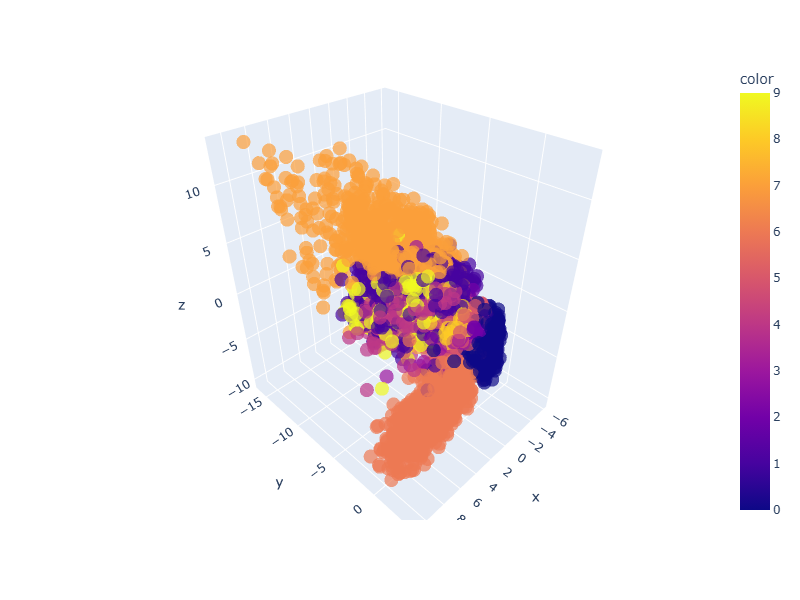

In [ ]:
pca_model_1 = PCA(n_components=3)
pca_model_1.fit(train_data_np)

PCA(n_components=3)

In [ ]:
test_data_with_pca_1 = pca_model_1.transform(test_data_np)

In [ ]:
test_data_with_pca_1.shape

(10000, 3)

In [ ]:
pca_df_1 = pd.DataFrame()
pca_df_1[['pca_x', 'pca_y', 'pca_z']] = test_data_with_pca_1
pca_df_1.head(2)

,pca_x,pca_y,pca_z
0,-332.271169,-747.798716,42.844819
1,20.696962,955.584583,152.715517


In [ ]:
pca_df_1 = pd.concat([pca_df_1, label_df], axis = 1)

In [ ]:
pca_df_1.head(2)

,pca_x,pca_y,pca_z,label
0,-332.271169,-747.798716,42.844819,8
1,20.696962,955.584583,152.715517,4


In [ ]:
fig = px.scatter_3d(x=pca_df_1['pca_x'], y=pca_df_1['pca_y'], z=pca_df_1['pca_z'], color=pca_df_1['label'])
fig.show()

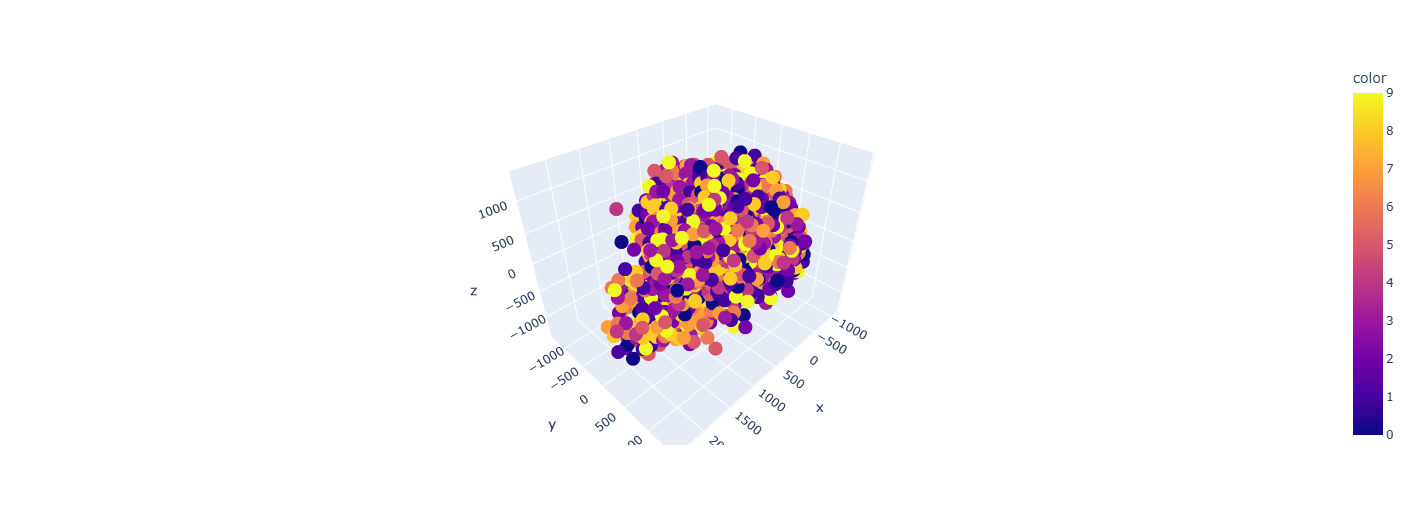

## Conclusion
- Autoencoders is a deep learning based unsupervised algorithm that can be used for dimensionality reduction.
- While PCA is one of the most widely used technique for dimensionality reduction, one must be aware of it's limitations.
- Autoencoders are widely used for tasks other than dimensionality reduction such as:
  - **Denoising**: If we pass noisy input / images as input, Autoencoder provides denoised data / images as output.
  - **Anamoly detection**: If anamolous data is passed to the Autoencoder, the reconstruction loss would be quite high which would be indicative of anamolous data.
  - **Image / data generation**: A special type of Autoencoders called as Variational Autoencoders (VAE) are used to generate novel data / images.